In [1]:
import torch.nn as nn
import torch

from fastervit import FasterViT

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A

/home/vladislav/miniconda3/envs/mask2former_cv703/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
categories = [        {
            "id": 1,
            "name": "1",
            "supercategory": ""
        },
        {
            "id": 2,
            "name": "2",
            "supercategory": ""
        },
        {
            "id": 3,
            "name": "3",
            "supercategory": ""
        },
        {
            "id": 4,
            "name": "4",
            "supercategory": ""
        },
        {
            "id": 5,
            "name": "5",
            "supercategory": ""
        },
        {
            "id": 6,
            "name": "6",
            "supercategory": ""
        },
        {
            "id": 7,
            "name": "7",
            "supercategory": ""
        },
        {
            "id": 8,
            "name": "8",
            "supercategory": ""
        },
        {
            "id": 9,
            "name": "9",
            "supercategory": ""
        },
        {
            "id": 10,
            "name": "9a",
            "supercategory": ""
        },
        {
            "id": 11,
            "name": "10",
            "supercategory": ""
        },
        {
            "id": 12,
            "name": "10a",
            "supercategory": ""
        },
        {
            "id": 13,
            "name": "11",
            "supercategory": ""
        },
        {
            "id": 14,
            "name": "12",
            "supercategory": ""
        },
        {
            "id": 15,
            "name": "12a",
            "supercategory": ""
        },
        {
            "id": 16,
            "name": "13",
            "supercategory": ""
        },
        {
            "id": 17,
            "name": "14",
            "supercategory": ""
        },
        {
            "id": 18,
            "name": "14a",
            "supercategory": ""
        },
        {
            "id": 19,
            "name": "15",
            "supercategory": ""
        },
        {
            "id": 20,
            "name": "16",
            "supercategory": ""
        },
        {
            "id": 21,
            "name": "16a",
            "supercategory": ""
        },
        {
            "id": 22,
            "name": "16b",
            "supercategory": ""
        },
        {
            "id": 23,
            "name": "16c",
            "supercategory": ""
        },
        {
            "id": 24,
            "name": "12b",
            "supercategory": ""
        },
        {
            "id": 25,
            "name": "14b",
            "supercategory": ""
        },
]

id2label = {cat['id']: cat['name'] for cat in categories}
label2id = {cat['name']: cat['id'] for cat in categories}

In [5]:
import numpy as np
# from pycocotools import mask as maskUtils
# from shapely.geometry import Polygon
import cv2
from PIL import Image
import os
from collections import defaultdict
def coco_to_polygons(annotations, image_folder):
    name_id = {image["id"]: image["file_name"] for image in annotations["images"]}
    polygons = defaultdict(list)
    classes = defaultdict(list)
    for ann in annotations["annotations"]:
        polygons[ann["image_id"]].append(np.array(ann["segmentation"][0], dtype=np.int32).reshape(-1, 2))
        classes[ann["image_id"]].append(ann["category_id"])

    # Create empty numpy arrays for each image
    dataset = [{} for _ in range(len(annotations["images"]))]
    # Draw polygons on the image arrays
    for class_list, (image_id, polygon_list) in zip(classes.values(), polygons.items()):
        template = np.zeros((annotations["images"][image_id-1]["height"], annotations["images"][image_id-1]["width"], 3), dtype=np.uint8)
        for j, (polygon, instance_class) in enumerate(zip(polygon_list, class_list), start=1):
            cv2.fillPoly(template, [polygon], (instance_class, j, 0))
        dataset[image_id-1]["annotation"] = template
        image = Image.open(os.path.join(image_folder, f"{name_id[image_id]}")).convert("RGB")
        dataset[image_id-1]["image"] = image

    for i, image in enumerate(dataset):
        if not image:
            print(f"Image {i+1} is missing")
            print()
            del dataset[i]

            
    return dataset

In [6]:
with open(r"/home/vladislav/Documents/Studies/CV703/final project/data/syntax/test/annotations/test.json") as f:
    data = json.load(f)
    test = coco_to_polygons(data, r"/home/vladislav/Documents/Studies/CV703/final project/data/syntax/test/images")


In [7]:
from transformers import MaskFormerImageProcessor
import PIL
processor = MaskFormerImageProcessor(reduce_labels=True, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False, resample="bicubic")

/home/vladislav/miniconda3/envs/mask2former_cv703/lib/python3.12/site-packages/transformers/models/maskformer/image_processing_maskformer.py:430: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


## Create PyTorch Dataset


In [9]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, processor, transform=None):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.processor = processor
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]["image"].convert("RGB"))

        instance_seg = np.array(self.dataset[idx]["annotation"])[:,:,1]
        class_id_map = np.array(self.dataset[idx]["annotation"])[:,:,0]
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            image, instance_seg = transformed['image'], transformed['mask']
            # convert to C, H, W
            image = image.transpose(2,0,1)

        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
          inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
          inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs

In [10]:
ADE_MEAN = [0.485, 0.456, 0.406]
ADE_STD = [0.229, 0.224, 0.225]

train_transform = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_dataset = ImageSegmentationDataset(test, processor=processor, transform=train_transform)

In [11]:
inputs = train_dataset[0]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
pixel_mask torch.Size([224, 224])
mask_labels torch.Size([4, 224, 224])
class_labels torch.Size([4])


In [12]:
inputs["class_labels"]

tensor([19,  0,  1,  2])

In [13]:
inputs = train_dataset[1]
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
pixel_mask torch.Size([224, 224])
mask_labels torch.Size([5, 224, 224])
class_labels torch.Size([5])


In [14]:
inputs["class_labels"]

tensor([5, 7, 8, 6, 4])

In [15]:
from torch.utils.data import DataLoader 

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [16]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([2, 3, 224, 224])
pixel_mask torch.Size([2, 224, 224])
class_labels 2
mask_labels 2


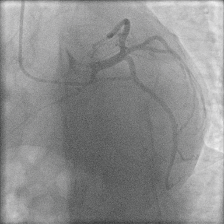

In [17]:
from PIL import Image

batch_index = 1

unnormalized_image = (batch["pixel_values"][batch_index].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In this case, there are many class labels it seems.

In [18]:
batch["class_labels"][batch_index]

tensor([ 4, 24, 15, 12, 13])

In [20]:
batch["mask_labels"][batch_index].shape

torch.Size([5, 224, 224])

Let's visualize a couple of them, see if they make sense.

Visualizing mask for: 4


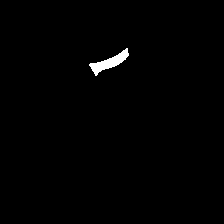

In [21]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][0].item()])

visual_mask = (batch["mask_labels"][batch_index][0].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)

In [ ]:
from transformers import MaskFormerForInstanceSegmentation
encoder = FasterViT(dim=64,in_dim=64,depths=[3,3,8,5], window_size=[7,7,7,7], ct_size=2, mlp_ratio=4, num_heads=[2,4,8,16], num_classes=1024)

# Load the model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade", id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
model.model.pixel_level_module.encoder = encoder
model.load_state_dict(torch.load("model_state_dict.pth"))


## Inference

After training, we can use the model to make predictions on new data.

Let's showcase this one of the examples of the training set.

In [48]:
def compute_dice_score(predicted, true):
    intersection = np.bitwise_and(predicted, true).sum()
    union = predicted.sum() + true.sum()
    dice_score = (2 * intersection) / (union + 1e-8)  # Add a small epsilon to avoid division by zero
    return dice_score

In [49]:
def compute_precision(predicted, true):
    true_positive = np.bitwise_and(predicted, true).sum()
    predicted_positive = predicted.sum()
    precision = true_positive / (predicted_positive + 1e-8)  # Add a small epsilon to avoid division by zero
    return precision

In [50]:
def compute_recall(predicted, true):
    true_positive = np.bitwise_and(predicted, true).sum()
    true = true.sum()
    recall = true_positive / (true + 1e-8)  # Add a small epsilon to avoid division by zero
    return recall

In [51]:
def compute_mAP(predicted, true):
    precision = compute_precision(predicted, true)
    recall = compute_recall(predicted, true)
    mAP = 2 * (precision * recall) / (precision + recall + 1e-8)  # Add a small epsilon to avoid division by zero
    return mAP

In [52]:
import numpy as np

def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask).astype(np.uint8)
  return visual_mask

In [109]:
import torch
model.eval()
dice_scores = []
precision_scores = []
recall_scores = []
with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_dataloader)):
        outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )

        # Assuming `outputs` contains the predicted masks and `batch` contains the true masks
        results = processor.post_process_instance_segmentation(outputs, target_sizes=[(56,56)]*batch["pixel_values"].shape[0])
        
        for result, true_mask, image in zip(results, batch["mask_labels"], batch["pixel_values"]):
            combined_pred = torch.zeros(56, 56)
            for segment in result['segments_info']:

                mask = get_mask(result['segmentation'], segment['id'])
                combined_pred += mask
            combined_pred = combined_pred.cpu().numpy()
            combined_pred = cv2.resize(combined_pred, (224, 224), interpolation=cv2.INTER_AREA)
            combined_pred = (combined_pred > 0)*1
            complete_mask = torch.sum(true_mask, dim=0).cpu().int().numpy()
            dice_score = compute_dice_score(combined_pred, complete_mask)
            recall_score = compute_recall(combined_pred, complete_mask)
            precision_score = compute_precision(combined_pred, complete_mask)
            dice_scores.append(dice_score.item())
            recall_scores.append(recall_score)
            precision_scores.append(precision_score)
            break
        
average_dice_score = sum(dice_scores) / len(dice_scores)
average_precision_score = sum(precision_scores) / len(precision_scores)
average_recall_score = sum(recall_scores) / len(recall_scores)

100%|██████████| 150/150 [00:04<00:00, 33.32it/s]


In [110]:
average_dice_score, average_recall_score, average_precision_score

(0.7034204196110235, 0.7587563942638952, 0.6648168731439684)

The predictions include 2 things, a predicted segmentation map and a corresponding segments_info, which includes more information about the segments of the map.

In [56]:
from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, torch.rand(1, 3, 224, 224).cuda())

In [ ]:
print(f"Flops_total {flops.total()}")

In [58]:
def plot_img_and_preds(image_dict):
    image = image_dict["image"].cpu().numpy().copy()
    image *= ADE_STD[0]
    image += ADE_MEAN[0]
    image *= 255
    image = image.astype(np.uint8)
    image = np.stack([image]*3, axis=-1)
    image[image_dict["true"]>0] = [255, 0, 0]
    image[image_dict["pred"]>0] = [0, 0, 255] 
    image[np.bitwise_and(image_dict["true"]>0, image_dict["pred"]>0)] = [0, 255, 0]
    plt.imshow(image)
    plt.axis('off')

In [59]:
images[2]["dice"]

0.6968775020004854

In [60]:
[score["dice"] for score in images]

[0.7214741318203807,
 0.708994708993078,
 0.6968775020004854,
 0.6224999999980547,
 0.6121638693365599,
 0.6355287326144436,
 0.6489985838546449,
 0.6933607118388317,
 0.6594202898510905,
 0.669538991812431,
 0.653117359412205,
 0.638475593838062,
 0.6966560509540274,
 0.620137931032772,
 0.6919605549044092,
 0.7050359712214366,
 0.6077324973863998,
 0.6480144404312635,
 0.6403884604380452,
 0.6129449838167866,
 0.6793365583943354,
 0.6308356218112381,
 0.64681684622792,
 0.6538020634301609,
 0.6148809523791224,
 0.6104830421345813,
 0.7668585526300024,
 0.6185173401189357,
 0.7539911521431929,
 0.6609697194860469,
 0.6415380723484909,
 0.7528279181690666,
 0.694208341568108,
 0.7750497677487833,
 0.6038239217416544,
 0.6754690757454819,
 0.6928999144553188,
 0.7768421052619897,
 0.6613561297830555,
 0.606366851943895,
 0.7730727470131824,
 0.6694588708315138,
 0.6951456310662739,
 0.6222059362392411,
 0.6470980653747596,
 0.7007672634254807,
 0.7574445046000069,
 0.6329519450786432,
 

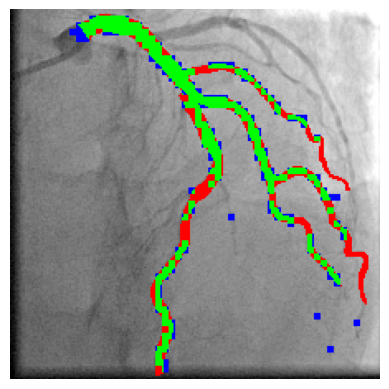

In [61]:
plot_img_and_preds(images[0])

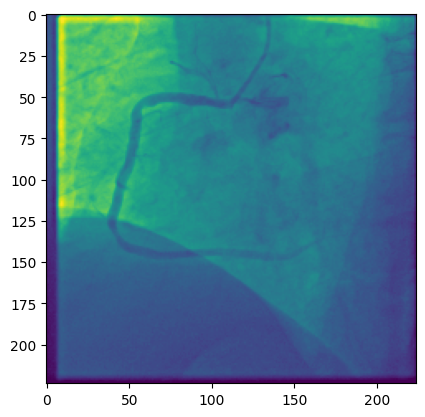

In [62]:
plt.imshow(batch["pixel_values"][-1][0])

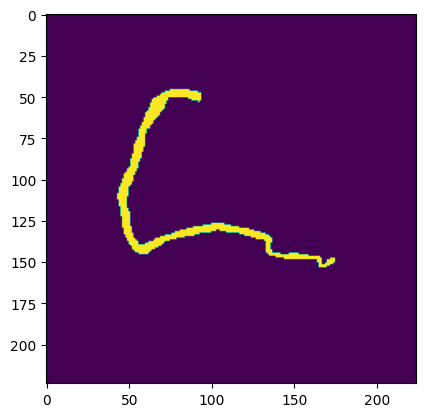

In [63]:
plt.imshow(complete_mask)

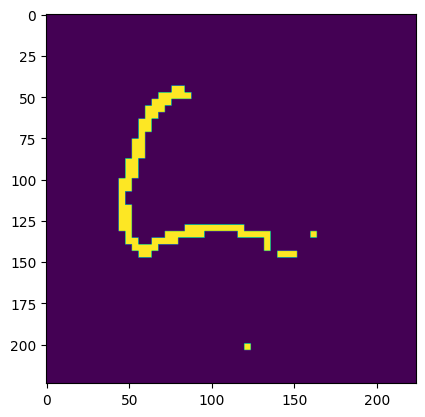

In [64]:
plt.imshow(combined_pred)

In [ ]:
compute_dice_score(combined_pred, complete_mask)

0.7057553956809146

# Test and visualize specific classes

In [150]:
import torch

# forward pass
with torch.no_grad():
  for batch in test_dataloader:
    x, y = batch["pixel_values"], batch["pixel_mask"]
    outputs = model(x.to(device), pixel_mask=y.to(device))


In [151]:
# you can pass them to processor for postprocessing
results = processor.post_process_instance_segmentation(outputs, target_sizes=[(224,224)]*4)
for result in results:
    print(result.keys())


dict_keys(['segmentation', 'segments_info'])
dict_keys(['segmentation', 'segments_info'])


In [152]:
for result in results:
  for segment in result['segments_info']:
    print(segment)

{'id': 0, 'label_id': 2, 'was_fused': False, 'score': 0.908494}
{'id': 1, 'label_id': 3, 'was_fused': False, 'score': 0.880651}
{'id': 2, 'label_id': 19, 'was_fused': False, 'score': 0.606667}
{'id': 3, 'label_id': 1, 'was_fused': False, 'score': 0.925309}
{'id': 4, 'label_id': 0, 'was_fused': False, 'score': 0.923432}
{'id': 0, 'label_id': 2, 'was_fused': False, 'score': 0.923499}
{'id': 1, 'label_id': 3, 'was_fused': False, 'score': 0.846201}
{'id': 2, 'label_id': 19, 'was_fused': False, 'score': 0.769051}
{'id': 3, 'label_id': 1, 'was_fused': False, 'score': 0.900975}
{'id': 4, 'label_id': 0, 'was_fused': False, 'score': 0.972633}


Let's visualize the predicted binary masks of the segments:

In [153]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_instances(image, masks, colors):
    # Convert image to numpy array
    image = np.array(image).reshape(224, 224).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Create a blank canvas with the same shape as the image
    canvas = np.zeros((224, 224, 3), dtype=np.uint8)

    # Iterate over each mask and color
    for mask, color in zip(masks, colors):
        # Apply the mask to the canvas using the color
        canvas[mask > 0] = color

    # Overlay the canvas on top of the image
    overlay = cv2.addWeighted(image, 0.7, canvas, 0.3, 0)

    # Plot the image with the overlay
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


Visualizing mask for instance of class  3
Visualizing mask for instance of class  4
Visualizing mask for instance of class  2
Visualizing mask for instance of class  1


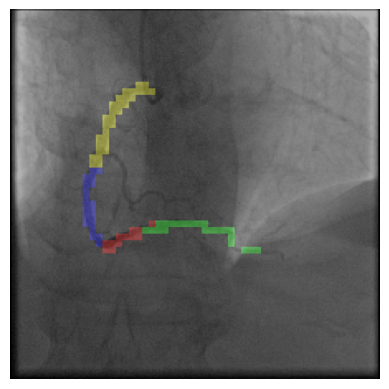

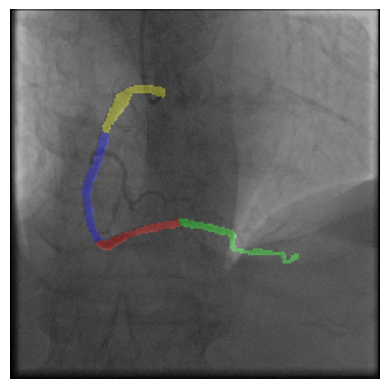

------
Visualizing mask for instance of class  3
Visualizing mask for instance of class  2
Visualizing mask for instance of class  1


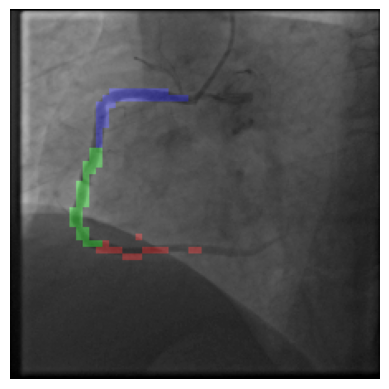

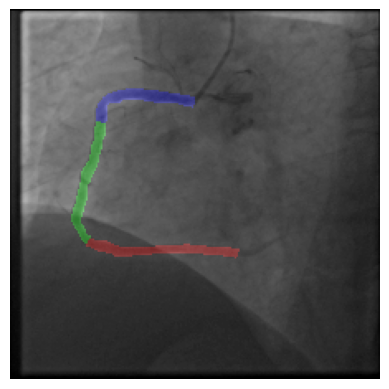

------


In [154]:
colors = [
    (255, 0, 0),     # Red
    (0, 255, 0),     # Green
    (0, 0, 255),     # Blue
    (255, 255, 0),   # Yellow
    (255, 0, 255),   # Magenta
    (0, 255, 255),   # Cyan
    (128, 0, 0),     # Maroon
    (0, 128, 0),     # Green (Dark)
    (0, 0, 128),     # Navy
    (128, 128, 0),   # Olive
    (128, 0, 128),   # Purple
    (0, 128, 128),   # Teal
    (255, 128, 0),   # Orange
    (128, 255, 0),   # Lime
    (0, 128, 255),   # Sky Blue
    (255, 0, 128),   # Pink
    (128, 0, 255),   # Violet
    (0, 255, 128),   # Spring Green
    (255, 128, 128), # Salmon
    (128, 255, 128), # Mint Green
    (128, 128, 255), # Periwinkle
    (255, 255, 128), # Light Yellow
    (255, 128, 255), # Orchid
    (128, 255, 255), # Aqua
    (192, 192, 192), # Silver
    (128, 128, 128), # Gray
    (0, 0, 0)        # Black
]

for img_id, result in enumerate(results):
    cls2id = {cl.item():idx for idx, cl in enumerate(batch["class_labels"][img_id])}
    included_masks_pred = []
    included_masks_true = []
    for segment in result['segments_info']:
        try:
            batch["mask_labels"][img_id][cls2id[segment['label_id']]]
            print("Visualizing mask for instance of class ", model.config.id2label[segment['label_id']+1])
            mask = get_mask(result['segmentation'], segment['id'])
            included_masks_pred.append(cv2.resize(mask, (224,224), interpolation=cv2.INTER_AREA))
            included_masks_true.append(batch["mask_labels"][img_id][cls2id[segment['label_id']]])
            
        except:
            continue
    visualize_instances(((batch["pixel_values"][img_id][0] * ADE_STD[0])+ADE_MEAN[0])*255, included_masks_pred, colors[:len(included_masks_pred)])  
    visualize_instances(((batch["pixel_values"][img_id][0] * ADE_STD[0])+ADE_MEAN[0])*255, included_masks_true, colors[:len(included_masks_true)])          

    print("------")
